<a href="https://colab.research.google.com/github/open-mmlab/mmaction2/blob/master/demo/mmaction2_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:

# Install some optional requirements
# !pip install -r requirements/optional.txt

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
import decord
import pickle

1.7.0+cu110 True
0.12.0
11.0
GCC 7.5


In [4]:
cd ..

/home/actrec/.virtualenvs/mmaction/mmaction2


In [1]:
ls

checkpoints/  demo/        LICENSE              README.md         setup.cfg
childact-mm/  docker/      mmaction/            README_zh-CN.md   setup.py
configs/      docs/        mmaction2.egg-info/  requirements/     tests/
data/         docs_zh_CN/  my-mmaction.ipynb    requirements.txt  tools/


# TSN 90.48% 

In [11]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

In [25]:
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/   .pth \
#       -O checkpoints/db3c461.pth

--2021-03-22 01:46:07--  https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics600_rgb/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99220779 (95M) [application/octet-stream]
Saving to: ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’

checkpoints/tsn_r50 100%[===================>]  94,62M  10,5MB/s    in 11s     

2021-03-22 01:46:22 (8,61 MB/s) - ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’ saved [99220779/99220779]



In [12]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = './checkpoints/best_top1_acc_epoch_5.pth'
cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-mm/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 32
cfg.optimizer.lr = 0.0001
# cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 30

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 10

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNet',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False),
    cls_head=dict(
        type='TSNHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.4,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(type='SGD', lr=0.0001, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dict(policy='step', step=[40, 80])
total_epochs = 30
checkpoint_config = dict(interval=2)
log_config = dict(interval=10, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = './childact-mm/latest.pth'
workflow = [('train', 1)]
dataset_type = 'VideoDataset'
data_root = 'data/childact_split/train/'
data_root_val = 'dat

### Train a new recognizer

Finally, lets initialize the dataset and recognizer, then train a new recognizer!

In [13]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-22 16:04:14,045 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight'}


Use load_from_torchvision loader


2021-03-22 16:04:16,416 - mmaction - INFO - load checkpoint from ./childact-mm/latest.pth
2021-03-22 16:04:16,417 - mmaction - INFO - Use load_from_local loader
2021-03-22 16:04:16,539 - mmaction - INFO - resumed epoch 12, iter 561
2021-03-22 16:04:16,541 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-mm
2021-03-22 16:04:16,542 - mmaction - INFO - workflow: [('train', 1)], max: 30 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
2021-03-22 16:05:56,931 - mmaction - INFO - Epoch [13][10/33]	lr: 5.000e-04, eta: 1:10:06, time: 10.039, data_time: 9.158, memory: 21448, top1_acc: 0.9375, top5_acc: 1.0000, loss_cls: 0.2199, loss: 0.2199, grad_norm: 3.0833
2021-03-22 16:07:05,519 - mmaction - INFO - Epoch [13][20/33]	lr: 5.000e-04, eta: 0:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 35s, ETA:     0s

2021-03-22 16:19:08,703 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 16:19:08,705 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-22 16:19:08,706 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 16:19:08,707 - mmaction - INFO - 
mean_acc	0.8492
2021-03-22 16:19:09,000 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-03-22 16:19:09,001 - mmaction - INFO - Best top1_acc is 0.8492 at 15 epoch.
2021-03-22 16:19:09,002 - mmaction - INFO - Epoch(val) [15][33]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-22 16:20:54,290 - mmaction - INFO - Epoch [16][10/33]	lr: 5.000e-04, eta: 0:44:12, time: 10.529, data_time: 9.656, memory: 21448, top1_acc: 0.8656, top5_acc: 1.0000, loss_cls: 0.3135, loss: 0.3135, grad_norm: 5.0392
2021-03-22 16:22:01,583 - mmaction - INFO - Epoch [16][20/33]	lr: 5.000e-04, eta: 0:42:08, time: 6.729, data_time: 5.830, memory: 21448, top1_acc: 0.9094, top5_acc: 0.9969,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-22 16:43:42,967 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 16:43:42,969 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-22 16:43:42,970 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 16:43:42,971 - mmaction - INFO - 
mean_acc	0.8571
2021-03-22 16:43:43,294 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-03-22 16:43:43,295 - mmaction - INFO - Best top1_acc is 0.8571 at 20 epoch.
2021-03-22 16:43:43,296 - mmaction - INFO - Epoch(val) [20][33]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-22 16:45:20,813 - mmaction - INFO - Epoch [21][10/33]	lr: 5.000e-04, eta: 0:21:02, time: 9.751, data_time: 8.872, memory: 21448, top1_acc: 0.8875, top5_acc: 1.0000, loss_cls: 0.2959, loss: 0.2959, grad_norm: 5.2473
2021-03-22 16:46:30,437 - mmaction - INFO - Epoch [21][20/33]	lr: 5.000e-04, eta: 0:19:34, time: 6.962, data_time: 6.085, memory: 21448, top1_acc: 0.8875, top5_acc: 1.0000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-22 17:08:12,494 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 17:08:12,496 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-22 17:08:12,496 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 17:08:12,497 - mmaction - INFO - 
mean_acc	0.8571
2021-03-22 17:08:12,497 - mmaction - INFO - Epoch(val) [25][33]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-22 17:09:53,555 - mmaction - INFO - Epoch [26][10/33]	lr: 5.000e-04, eta: -1 day, 23:58:40, time: 10.105, data_time: 9.229, memory: 21448, top1_acc: 0.8969, top5_acc: 1.0000, loss_cls: 0.2787, loss: 0.2787, grad_norm: 4.8332
2021-03-22 17:11:02,020 - mmaction - INFO - Epoch [26][20/33]	lr: 5.000e-04, eta: -1 day, 23:57:19, time: 6.847, data_time: 5.975, memory: 21448, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2513, loss: 0.2513, grad_norm: 5.1216
2021-03-22 17:12:38,741 - mmaction - INFO - Epoch [26][30/33]	lr: 5.000e-04, eta: -1 day, 23:55:57, time: 9.672, dat

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-22 17:32:40,845 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 17:32:40,847 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-03-22 17:32:40,848 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 17:32:40,849 - mmaction - INFO - 
mean_acc	0.8413
2021-03-22 17:32:40,850 - mmaction - INFO - Epoch(val) [30][33]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413


## Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [14]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=16,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.1 task/s, elapsed: 59s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9048
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9048
top1_acc: 0.9048
top5_acc: 1.0000
mean_class_accuracy: 0.9048


# SlowFast 91.27%

In [2]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth \
      -O checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth

--2021-03-22 18:16:35--  https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138274276 (132M) [application/octet-stream]
Saving to: ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’

checkpoints/slowfas 100%[===================>] 131,87M  6,72MB/s    in 17s     

2021-03-22 18:16:55 (7,79 MB/s) - ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’ saved [138274276/138274276]



In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb.py')

In [3]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './childact-checkpoints/childact-slowfast2/best_top1_acc_epoch_5.pth'
# cfg.resume_from = './childact-checkpoints/childact-slowfast/best_top1_acc_epoch_50.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-slowfast3/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
# cfg.data.workers_per_gpu = 4
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 5

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')


In [9]:
# del cfg.optimizer['momentum']

### Train a new recognizer

Finally, lets initialize the dataset and recognizer, then train a new recognizer!

In [4]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-24 13:17:39,463 - mmaction - INFO - load checkpoint from ./childact-checkpoints/childact-slowfast2/best_top1_acc_epoch_5.pth
2021-03-24 13:17:39,464 - mmaction - INFO - Use load_from_local loader
2021-03-24 13:17:40,173 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-slowfast3
2021-03-24 13:17:40,174 - mmaction - INFO - workflow: [('train', 1)], max: 5 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed outp

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.3 task/s, elapsed: 20s, ETA:     0s

2021-03-24 13:30:14,656 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 13:30:14,658 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-24 13:30:14,658 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 13:30:14,659 - mmaction - INFO - 
mean_acc	0.8571
2021-03-24 13:30:15,020 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-24 13:30:15,021 - mmaction - INFO - Best top1_acc is 0.8571 at 5 epoch.
2021-03-24 13:30:15,021 - mmaction - INFO - Epoch(val) [5][66]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571


In [5]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
import gc
# gc.enable()
gc.collect()

0

## Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [31]:
from mmaction.apis import single_gpu_test, inference_recognizer, init_recognizer
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

In [5]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# checkpoint = './childact-checkpoints/childact-slowfast/best_top1_acc_epoch_50.pth'
# modelt = init_recognizer(cfg, checkpoint, device='cuda:0')
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=2,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.4 task/s, elapsed: 303s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9127
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9127
top1_acc: 0.9127
top5_acc: 1.0000
mean_class_accuracy: 0.9127


In [ ]:
# mmaction.core.evaluation.confusion_matrix()
# gt_confusion_matrix()

# R(2+1)D

In [6]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth \
      -O checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth

--2021-03-24 13:44:27--  https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255320099 (243M) [application/octet-stream]
Saving to: ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’

checkpoints/r2plus1 100%[===================>] 243,49M  6,98MB/s    in 32s     

2021-03-24 13:45:05 (7,72 MB/s) - ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’ saved [255320099/255320099]



In [26]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb.py')

In [27]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = './checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth'
cfg.resume_from = './childact-checkpoints/childact-r2plus1d/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-r2plus1d/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
cfg.optimizer.type = 'Adam'
cfg.optimizer.weight_decay=0.0001

cfg.optimizer_config.grad_clip=None
cfg.optimizer.lr = 0.01

cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 151

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.model.backbone.norm_cfg.type = 'BN3d'
# cfg.model.cls_head.type = 'X3DHead'
del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet2Plus1d',
        depth=34,
        pretrained=None,
        pretrained2d=False,
        norm_eval=False,
        conv_cfg=dict(type='Conv2plus1d'),
        norm_cfg=dict(type='BN3d', requires_grad=True, eps=0.001),
        conv1_kernel=(3, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(1, 1, 1, 1),
        spatial_strides=(1, 2, 2, 2),
        temporal_strides=(1, 2, 2, 2),
        zero_init_residual=False,
        act_cfg=dict(type='ReLU')),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=512,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=7)
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/r2plus1d_r34_video_8

In [28]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-24 14:32:25,738 - mmaction - INFO - load checkpoint from ./checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
2021-03-24 14:32:25,739 - mmaction - INFO - Use load_from_local loader
2021-03-24 14:32:25,890 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 512]) from checkpoint, the shape in current model is torch.Size([7, 512]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-24 14:32:25,891 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-r2plus1d
2021-03-24 14:32:25,892 - mmaction - INFO - workflow: [('train', 1)], max: 50 epochs
2021-03-24 14:33:32,975 - mmaction - INFO - Epoch [1][40/66]	lr: 1.000e-02, eta: 1:31:06, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 14:41:51,620 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 14:41:51,623 - mmaction - INFO - 
top1_acc	0.3016
top5_acc	1.0000
2021-03-24 14:41:51,624 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 14:41:51,626 - mmaction - INFO - 
mean_acc	0.3016
2021-03-24 14:41:52,616 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-24 14:41:52,617 - mmaction - INFO - Best top1_acc is 0.3016 at 5 epoch.
2021-03-24 14:41:52,618 - mmaction - INFO - Epoch(val) [5][66]	top1_acc: 0.3016, top5_acc: 1.0000, mean_class_accuracy: 0.3016
2021-03-24 14:43:00,926 - mmaction - INFO - Epoch [6][40/66]	lr: 9.755e-03, eta: 0:53:58, time: 1.707, data_time: 1.028, memory: 11178, top1_acc: 0.3141, top5_acc: 0.9625, loss_cls: 1.5000, loss: 1.5000
2021-03-24 14:44:50,937 - mmaction - INFO - Epoch [7][40/66]	lr: 9.649e-03, eta: 0:52:19, time: 1.724, data_time: 1.045, memory: 11178, top1_acc: 0.2891, top5_acc: 0.9313, loss_cls: 1.6030, loss: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 14:51:13,792 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 14:51:13,794 - mmaction - INFO - 
top1_acc	0.2063
top5_acc	0.9444
2021-03-24 14:51:13,795 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 14:51:13,796 - mmaction - INFO - 
mean_acc	0.2063
2021-03-24 14:51:13,797 - mmaction - INFO - Epoch(val) [10][66]	top1_acc: 0.2063, top5_acc: 0.9444, mean_class_accuracy: 0.2063
2021-03-24 14:52:21,981 - mmaction - INFO - Epoch [11][40/66]	lr: 9.045e-03, eta: 0:46:36, time: 1.704, data_time: 1.030, memory: 11178, top1_acc: 0.3688, top5_acc: 0.9625, loss_cls: 1.4341, loss: 1.4341
2021-03-24 14:54:09,767 - mmaction - INFO - Epoch [12][40/66]	lr: 8.853e-03, eta: 0:45:21, time: 1.743, data_time: 1.067, memory: 11178, top1_acc: 0.2859, top5_acc: 0.9500, loss_cls: 1.5347, loss: 1.5347
2021-03-24 14:55:58,080 - mmaction - INFO - Epoch [13][40/66]	lr: 8.645e-03, eta: 0:44:01, time: 1.693, data_time: 1.017, memory: 11178, top1_acc: 0.3297, top5_acc: 0.9719, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.4 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:00:24,292 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:00:24,295 - mmaction - INFO - 
top1_acc	0.3810
top5_acc	1.0000
2021-03-24 15:00:24,295 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:00:24,297 - mmaction - INFO - 
mean_acc	0.3810
2021-03-24 15:00:25,331 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-03-24 15:00:25,332 - mmaction - INFO - Best top1_acc is 0.3810 at 15 epoch.
2021-03-24 15:00:25,333 - mmaction - INFO - Epoch(val) [15][66]	top1_acc: 0.3810, top5_acc: 1.0000, mean_class_accuracy: 0.3810
2021-03-24 15:01:33,162 - mmaction - INFO - Epoch [16][40/66]	lr: 7.939e-03, eta: 0:40:07, time: 1.695, data_time: 1.020, memory: 11178, top1_acc: 0.3500, top5_acc: 0.9578, loss_cls: 1.4660, loss: 1.4660
2021-03-24 15:03:18,413 - mmaction - INFO - Epoch [17][40/66]	lr: 7.679e-03, eta: 0:38:51, time: 1.676, data_time: 1.003, memory: 11178, top1_acc: 0.3547, top5_acc: 0.9578, loss_cls: 1.4680, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:09:44,637 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:09:44,639 - mmaction - INFO - 
top1_acc	0.4127
top5_acc	1.0000
2021-03-24 15:09:44,640 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:09:44,641 - mmaction - INFO - 
mean_acc	0.4127
2021-03-24 15:09:45,665 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-03-24 15:09:45,666 - mmaction - INFO - Best top1_acc is 0.4127 at 20 epoch.
2021-03-24 15:09:45,667 - mmaction - INFO - Epoch(val) [20][66]	top1_acc: 0.4127, top5_acc: 1.0000, mean_class_accuracy: 0.4127
2021-03-24 15:10:54,647 - mmaction - INFO - Epoch [21][40/66]	lr: 6.545e-03, eta: 0:34:10, time: 1.724, data_time: 1.052, memory: 11178, top1_acc: 0.3625, top5_acc: 0.9547, loss_cls: 1.4422, loss: 1.4422
2021-03-24 15:11:33,890 - mmaction - INFO - Saving checkpoint at 21 epochs
2021-03-24 15:12:45,596 - mmaction - INFO - Epoch [22][40/66]	lr: 6.243e-03, eta: 0:33:02, time: 1.768, data_time: 1.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:19:00,266 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:19:00,268 - mmaction - INFO - 
top1_acc	0.4048
top5_acc	1.0000
2021-03-24 15:19:00,269 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:19:00,270 - mmaction - INFO - 
mean_acc	0.4048
2021-03-24 15:19:00,271 - mmaction - INFO - Epoch(val) [25][66]	top1_acc: 0.4048, top5_acc: 1.0000, mean_class_accuracy: 0.4048
2021-03-24 15:20:06,655 - mmaction - INFO - Epoch [26][40/66]	lr: 5.000e-03, eta: 0:28:13, time: 1.659, data_time: 0.987, memory: 11178, top1_acc: 0.4062, top5_acc: 0.9563, loss_cls: 1.3957, loss: 1.3957
2021-03-24 15:21:59,940 - mmaction - INFO - Epoch [27][40/66]	lr: 4.686e-03, eta: 0:27:05, time: 1.784, data_time: 1.111, memory: 11178, top1_acc: 0.3578, top5_acc: 0.9703, loss_cls: 1.4237, loss: 1.4237
2021-03-24 15:23:44,325 - mmaction - INFO - Epoch [28][40/66]	lr: 4.373e-03, eta: 0:25:54, time: 1.691, data_time: 1.017, memory: 11178, top1_acc: 0.3984, top5_acc: 0.9609, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:28:18,839 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:28:18,840 - mmaction - INFO - 
top1_acc	0.4762
top5_acc	1.0000
2021-03-24 15:28:18,841 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:28:18,842 - mmaction - INFO - 
mean_acc	0.4762
2021-03-24 15:28:19,865 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-03-24 15:28:19,866 - mmaction - INFO - Best top1_acc is 0.4762 at 30 epoch.
2021-03-24 15:28:19,867 - mmaction - INFO - Epoch(val) [30][66]	top1_acc: 0.4762, top5_acc: 1.0000, mean_class_accuracy: 0.4762
2021-03-24 15:29:26,630 - mmaction - INFO - Epoch [31][40/66]	lr: 3.455e-03, eta: 0:22:22, time: 1.669, data_time: 0.999, memory: 11178, top1_acc: 0.3812, top5_acc: 0.9578, loss_cls: 1.3876, loss: 1.3876
2021-03-24 15:31:13,870 - mmaction - INFO - Epoch [32][40/66]	lr: 3.159e-03, eta: 0:21:13, time: 1.709, data_time: 1.037, memory: 11178, top1_acc: 0.4016, top5_acc: 0.9703, loss_cls: 1.3885, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:37:33,647 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:37:33,650 - mmaction - INFO - 
top1_acc	0.4921
top5_acc	1.0000
2021-03-24 15:37:33,651 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:37:33,653 - mmaction - INFO - 
mean_acc	0.4921
2021-03-24 15:37:34,694 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2021-03-24 15:37:34,695 - mmaction - INFO - Best top1_acc is 0.4921 at 35 epoch.
2021-03-24 15:37:34,696 - mmaction - INFO - Epoch(val) [35][66]	top1_acc: 0.4921, top5_acc: 1.0000, mean_class_accuracy: 0.4921
2021-03-24 15:38:41,597 - mmaction - INFO - Epoch [36][40/66]	lr: 2.061e-03, eta: 0:16:34, time: 1.672, data_time: 1.002, memory: 11178, top1_acc: 0.4141, top5_acc: 0.9703, loss_cls: 1.3533, loss: 1.3533
2021-03-24 15:40:29,401 - mmaction - INFO - Epoch [37][40/66]	lr: 1.813e-03, eta: 0:15:25, time: 1.690, data_time: 1.018, memory: 11178, top1_acc: 0.3828, top5_acc: 0.9641, loss_cls: 1.3798, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.4 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:46:48,585 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:46:48,587 - mmaction - INFO - 
top1_acc	0.5000
top5_acc	1.0000
2021-03-24 15:46:48,588 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:46:48,589 - mmaction - INFO - 
mean_acc	0.5000
2021-03-24 15:46:49,615 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-24 15:46:49,616 - mmaction - INFO - Best top1_acc is 0.5000 at 40 epoch.
2021-03-24 15:46:49,617 - mmaction - INFO - Epoch(val) [40][66]	top1_acc: 0.5000, top5_acc: 1.0000, mean_class_accuracy: 0.5000
2021-03-24 15:48:02,324 - mmaction - INFO - Epoch [41][40/66]	lr: 9.549e-04, eta: 0:10:48, time: 1.817, data_time: 1.149, memory: 11178, top1_acc: 0.4219, top5_acc: 0.9578, loss_cls: 1.3856, loss: 1.3856
2021-03-24 15:49:52,341 - mmaction - INFO - Epoch [42][40/66]	lr: 7.784e-04, eta: 0:09:39, time: 1.715, data_time: 1.043, memory: 11178, top1_acc: 0.4141, top5_acc: 0.9719, loss_cls: 1.3213, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.4 task/s, elapsed: 15s, ETA:     0s

2021-03-24 15:56:11,961 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 15:56:11,964 - mmaction - INFO - 
top1_acc	0.5476
top5_acc	1.0000
2021-03-24 15:56:11,965 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 15:56:11,967 - mmaction - INFO - 
mean_acc	0.5476
2021-03-24 15:56:12,994 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2021-03-24 15:56:12,995 - mmaction - INFO - Best top1_acc is 0.5476 at 45 epoch.
2021-03-24 15:56:12,996 - mmaction - INFO - Epoch(val) [45][66]	top1_acc: 0.5476, top5_acc: 1.0000, mean_class_accuracy: 0.5476
2021-03-24 15:57:20,245 - mmaction - INFO - Epoch [46][40/66]	lr: 2.447e-04, eta: 0:05:03, time: 1.681, data_time: 1.011, memory: 11178, top1_acc: 0.4688, top5_acc: 0.9641, loss_cls: 1.3108, loss: 1.3108
2021-03-24 15:59:10,946 - mmaction - INFO - Epoch [47][40/66]	lr: 1.571e-04, eta: 0:03:54, time: 1.732, data_time: 1.062, memory: 11178, top1_acc: 0.4000, top5_acc: 0.9578, loss_cls: 1.3806, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-24 16:05:34,909 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 16:05:34,912 - mmaction - INFO - 
top1_acc	0.5476
top5_acc	1.0000
2021-03-24 16:05:34,912 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 16:05:34,915 - mmaction - INFO - 
mean_acc	0.5476
2021-03-24 16:05:34,916 - mmaction - INFO - Epoch(val) [50][66]	top1_acc: 0.5476, top5_acc: 1.0000, mean_class_accuracy: 0.5476


In [30]:
import pickle

with open('f'{cfg.work_dir}/model50e', 'wb') as f:
    pickle.dump(model, f)

In [34]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader, load_annotations, build_dataset
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.7 task/s, elapsed: 180s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5952
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.5952
top1_acc: 0.5952
top5_acc: 1.0000
mean_class_accuracy: 0.5952


<AxesSubplot:>

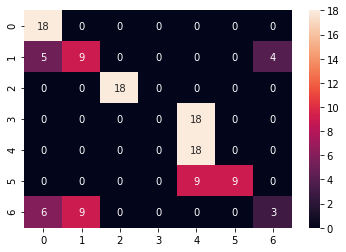

In [73]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True)

# TSM

In [2]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth \
      -O checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth

--2021-03-22 18:16:35--  https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138274276 (132M) [application/octet-stream]
Saving to: ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’

checkpoints/slowfas 100%[===================>] 131,87M  6,72MB/s    in 17s     

2021-03-22 18:16:55 (7,79 MB/s) - ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’ saved [138274276/138274276]



In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb.py')

In [3]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = './checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-r2plus1d/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
cfg.optimizer.type = 'Adam'
cfg.optimizer.weight_decay=0.0001

cfg.optimizer_config.grad_clip=None
cfg.optimizer.lr = 0.01

cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 50

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 7
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


In [4]:
del cfg.optimizer['momentum']

In [5]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-22 19:47:45,954 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-slowfast
2021-03-22 19:47:45,955 - mmaction - INFO - workflow: [('train', 1)], max: 50 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 20:00:23,057 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 20:00:23,059 - mmaction - INFO - 
top1_acc	0.5635
top5_acc	1.0000
2021-03-22 20:00:23,060 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 20:00:23,062 - mmaction - INFO - 
mean_acc	0.5635
2021-03-22 20:00:23,632 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-22 20:00:23,633 - mmaction - INFO - Best top1_acc is 0.5635 at 5 epoch.
2021-03-22 20:00:23,634 - mmaction - INFO - Epoch(val) [5][66]	top1_acc: 0.5635, top5_acc: 1.0000, mean_class_accuracy: 0.5635
2021-03-22 20:01:03,115 - mmaction - INFO - Epoch [6][15/66]	lr: 2.321e-03, eta: 1:42:36, time: 2.632, data_time: 1.736, memory: 12339, top1_acc: 0.4500, top5_acc: 0.9750, loss_cls: 1.2493, loss: 1.2493
2021-03-22 20:01:36,778 - mmaction - INFO - Epoch [6][30/66]	lr: 2.380e-03, eta: 1:42:25, time: 2.244, data_time: 1.331, memory: 12339, top1_acc: 0.4417, top5_acc: 0.9917, loss_cls: 1.3425, loss: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 20:13:00,840 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 20:13:00,843 - mmaction - INFO - 
top1_acc	0.6349
top5_acc	1.0000
2021-03-22 20:13:00,844 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 20:13:00,846 - mmaction - INFO - 
mean_acc	0.6349
2021-03-22 20:13:01,476 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-22 20:13:01,477 - mmaction - INFO - Best top1_acc is 0.6349 at 10 epoch.
2021-03-22 20:13:01,478 - mmaction - INFO - Epoch(val) [10][66]	top1_acc: 0.6349, top5_acc: 1.0000, mean_class_accuracy: 0.6349
2021-03-22 20:13:41,946 - mmaction - INFO - Epoch [11][15/66]	lr: 3.350e-03, eta: 1:30:28, time: 2.698, data_time: 1.792, memory: 12339, top1_acc: 0.4792, top5_acc: 0.9833, loss_cls: 1.1690, loss: 1.1690
2021-03-22 20:14:15,408 - mmaction - INFO - Epoch [11][30/66]	lr: 3.404e-03, eta: 1:30:07, time: 2.231, data_time: 1.312, memory: 12339, top1_acc: 0.5167, top5_acc: 0.9833, loss_cls: 1.1080, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 20:25:35,202 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 20:25:35,205 - mmaction - INFO - 
top1_acc	0.7619
top5_acc	1.0000
2021-03-22 20:25:35,206 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 20:25:35,208 - mmaction - INFO - 
mean_acc	0.7619
2021-03-22 20:25:35,825 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-03-22 20:25:35,826 - mmaction - INFO - Best top1_acc is 0.7619 at 15 epoch.
2021-03-22 20:25:35,827 - mmaction - INFO - Epoch(val) [15][66]	top1_acc: 0.7619, top5_acc: 1.0000, mean_class_accuracy: 0.7619
2021-03-22 20:26:12,605 - mmaction - INFO - Epoch [16][15/66]	lr: 3.991e-03, eta: 1:18:39, time: 2.451, data_time: 1.555, memory: 12339, top1_acc: 0.5000, top5_acc: 0.9708, loss_cls: 1.0873, loss: 1.0873
2021-03-22 20:26:47,546 - mmaction - INFO - Epoch [16][30/66]	lr: 4.038e-03, eta: 1:18:17, time: 2.329, data_time: 1.427, memory: 12339, top1_acc: 0.5625, top5_acc: 0.9833, loss_cls: 1.0458, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 20:38:12,703 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 20:38:12,706 - mmaction - INFO - 
top1_acc	0.6746
top5_acc	1.0000
2021-03-22 20:38:12,706 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 20:38:12,708 - mmaction - INFO - 
mean_acc	0.6746
2021-03-22 20:38:12,709 - mmaction - INFO - Epoch(val) [20][66]	top1_acc: 0.6746, top5_acc: 1.0000, mean_class_accuracy: 0.6746
2021-03-22 20:38:54,224 - mmaction - INFO - Epoch [21][15/66]	lr: 4.156e-03, eta: 1:07:33, time: 2.767, data_time: 1.856, memory: 12339, top1_acc: 0.5208, top5_acc: 0.9667, loss_cls: 1.1929, loss: 1.1929
2021-03-22 20:39:27,883 - mmaction - INFO - Epoch [21][30/66]	lr: 4.196e-03, eta: 1:07:06, time: 2.244, data_time: 1.315, memory: 12339, top1_acc: 0.5667, top5_acc: 0.9750, loss_cls: 1.1067, loss: 1.1067
2021-03-22 20:40:01,738 - mmaction - INFO - Epoch [21][45/66]	lr: 4.235e-03, eta: 1:06:39, time: 2.256, data_time: 1.321, memory: 12339, top1_acc: 0.6000, top5_acc: 0.9708, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.3 task/s, elapsed: 20s, ETA:     0s

2021-03-22 20:51:08,305 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 20:51:08,307 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-22 20:51:08,307 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 20:51:08,308 - mmaction - INFO - 
mean_acc	0.8016
2021-03-22 20:51:08,927 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2021-03-22 20:51:08,928 - mmaction - INFO - Best top1_acc is 0.8016 at 25 epoch.
2021-03-22 20:51:08,929 - mmaction - INFO - Epoch(val) [25][66]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-22 20:51:49,815 - mmaction - INFO - Epoch [26][15/66]	lr: 3.837e-03, eta: 0:56:20, time: 2.725, data_time: 1.831, memory: 12339, top1_acc: 0.6625, top5_acc: 0.9833, loss_cls: 0.8038, loss: 0.8038
2021-03-22 20:52:23,245 - mmaction - INFO - Epoch [26][30/66]	lr: 3.867e-03, eta: 0:55:52, time: 2.229, data_time: 1.328, memory: 12339, top1_acc: 0.6583, top5_acc: 0.9833, loss_cls: 0.9013, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 21:03:48,187 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 21:03:48,189 - mmaction - INFO - 
top1_acc	0.7460
top5_acc	1.0000
2021-03-22 21:03:48,190 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 21:03:48,191 - mmaction - INFO - 
mean_acc	0.7460
2021-03-22 21:03:48,192 - mmaction - INFO - Epoch(val) [30][66]	top1_acc: 0.7460, top5_acc: 1.0000, mean_class_accuracy: 0.7460
2021-03-22 21:04:28,485 - mmaction - INFO - Epoch [31][15/66]	lr: 3.108e-03, eta: 0:45:00, time: 2.686, data_time: 1.787, memory: 12339, top1_acc: 0.6042, top5_acc: 0.9917, loss_cls: 0.9208, loss: 0.9208
2021-03-22 21:05:03,435 - mmaction - INFO - Epoch [31][30/66]	lr: 3.129e-03, eta: 0:44:31, time: 2.330, data_time: 1.419, memory: 12339, top1_acc: 0.6000, top5_acc: 0.9875, loss_cls: 0.9167, loss: 0.9167
2021-03-22 21:05:32,025 - mmaction - INFO - Epoch [31][45/66]	lr: 3.150e-03, eta: 0:43:59, time: 1.906, data_time: 0.976, memory: 12339, top1_acc: 0.6625, top5_acc: 0.9833, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.5 task/s, elapsed: 19s, ETA:     0s

2021-03-22 21:16:19,925 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 21:16:19,927 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-03-22 21:16:19,927 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 21:16:19,929 - mmaction - INFO - 
mean_acc	0.8175
2021-03-22 21:16:20,539 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2021-03-22 21:16:20,540 - mmaction - INFO - Best top1_acc is 0.8175 at 35 epoch.
2021-03-22 21:16:20,541 - mmaction - INFO - Epoch(val) [35][66]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-03-22 21:17:00,917 - mmaction - INFO - Epoch [36][15/66]	lr: 2.061e-03, eta: 0:33:34, time: 2.691, data_time: 1.799, memory: 12339, top1_acc: 0.6792, top5_acc: 0.9875, loss_cls: 0.8449, loss: 0.8449
2021-03-22 21:17:36,667 - mmaction - INFO - Epoch [36][30/66]	lr: 2.061e-03, eta: 0:33:05, time: 2.383, data_time: 1.484, memory: 12339, top1_acc: 0.7083, top5_acc: 0.9958, loss_cls: 0.7828, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 21:29:01,018 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 21:29:01,020 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-22 21:29:01,020 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 21:29:01,022 - mmaction - INFO - 
mean_acc	0.8254
2021-03-22 21:29:01,660 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-22 21:29:01,661 - mmaction - INFO - Best top1_acc is 0.8254 at 40 epoch.
2021-03-22 21:29:01,662 - mmaction - INFO - Epoch(val) [40][66]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-22 21:29:40,568 - mmaction - INFO - Epoch [41][15/66]	lr: 9.549e-04, eta: 0:22:13, time: 2.594, data_time: 1.702, memory: 12339, top1_acc: 0.6625, top5_acc: 0.9792, loss_cls: 0.8165, loss: 0.8165
2021-03-22 21:30:16,044 - mmaction - INFO - Epoch [41][30/66]	lr: 9.549e-04, eta: 0:21:43, time: 2.365, data_time: 1.467, memory: 12339, top1_acc: 0.7542, top5_acc: 0.9875, loss_cls: 0.6915, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-22 21:41:47,273 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 21:41:47,275 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-22 21:41:47,276 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 21:41:47,277 - mmaction - INFO - 
mean_acc	0.8571
2021-03-22 21:41:47,904 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2021-03-22 21:41:47,905 - mmaction - INFO - Best top1_acc is 0.8571 at 45 epoch.
2021-03-22 21:41:47,906 - mmaction - INFO - Epoch(val) [45][66]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-22 21:42:28,871 - mmaction - INFO - Epoch [46][15/66]	lr: 2.447e-04, eta: 0:10:51, time: 2.731, data_time: 1.792, memory: 12339, top1_acc: 0.7083, top5_acc: 1.0000, loss_cls: 0.6688, loss: 0.6688
2021-03-22 21:43:01,248 - mmaction - INFO - Epoch [46][30/66]	lr: 2.447e-04, eta: 0:10:21, time: 2.158, data_time: 1.232, memory: 12339, top1_acc: 0.6833, top5_acc: 0.9958, loss_cls: 0.7538, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.3 task/s, elapsed: 20s, ETA:     0s

2021-03-22 21:54:38,155 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 21:54:38,156 - mmaction - INFO - 
top1_acc	0.8730
top5_acc	1.0000
2021-03-22 21:54:38,157 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 21:54:38,158 - mmaction - INFO - 
mean_acc	0.8730
2021-03-22 21:54:38,777 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_50.pth.
2021-03-22 21:54:38,778 - mmaction - INFO - Best top1_acc is 0.8730 at 50 epoch.
2021-03-22 21:54:38,779 - mmaction - INFO - Epoch(val) [50][66]	top1_acc: 0.8730, top5_acc: 1.0000, mean_class_accuracy: 0.8730


In [30]:
import pickle

with open('f'{cfg.work_dir}/model50e', 'wb') as f:
    pickle.dump(model, f)

In [5]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[                                                  ] 0/126, elapsed: 0s, ETA:

/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.4 task/s, elapsed: 310s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.1429
top5_acc	0.7143

Evaluating mean_class_accuracy ...

mean_acc	0.1429
top1_acc: 0.1429
top5_acc: 0.7143
mean_class_accuracy: 0.1429


<AxesSubplot:>

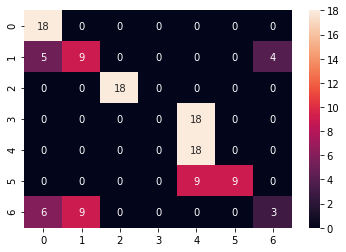

In [73]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True)